In [83]:
import pandas as pd
import numpy as np
act = pd.read_csv("D:/000-Master/UserClustering/sample_activity_Oct-22-2018.csv")
act.rename(columns = {'Unnamed: 0':'index'},inplace=True)
loc = pd.read_csv("D:/000-Master/UserClustering/sample_location_Oct-22-2018.csv")
loc.rename(columns = {'Unnamed: 0':'index'},inplace=True)
city_list = (dict(loc['city'].value_counts()))

act['start_date'] = act['local_start_time'].astype(str).str[:10]
act['local_start_time'] = act['local_start_time'].astype(str).str[:19]
act['local_start_time'] = pd.to_datetime(act['local_start_time'])
act['local_start_hour'] = act['local_start_time'].dt.hour

act['local_end_time'] = act['local_end_time'].astype(str).str[:19]
act['local_end_time'] = pd.to_datetime(act['local_end_time'])

### TUCSON ONLY ###
loc = loc.loc[loc['city'] == 'tucson']
act = act.loc[act['city'] == 'tucson']
import math
O = [min(loc['center_lat']),min(loc['center_lon'])]
loc['center_x'] = (loc['center_lon']-O[1])*111.2*np.cos(np.radians(loc['center_lat'])) # x - lon - km
loc['center_y'] = (loc['center_lat']-O[0])*111.2 # y - lat - km

# ###  Group by weekday and weekend
# from datetime import datetime, date, time
# def weekday(data):
#     dt = datetime.strptime(data, "%Y-%m-%d")
#     tt = dt.timetuple()
#     return tt[6]
    
# act['day'] = (act['start_date']).apply(weekday) # weekday (0 = Monday)
# wkn_act = act[(act.day >=5 )]
# wkd_act = act[(act.day <=4 )]

In [86]:
# Hierachical Cluster
data = loc.iloc[:,[1,10,11]]

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

X = data[['center_x','center_y']]
Z = linkage(X, 'complete')

from scipy.cluster.hierarchy import fcluster
assignments = fcluster(linkage(X, method='complete'),1.5,'distance')
data['labels'] = assignments

loc['labels'] = assignments

loc.head()
# print(max(loc['labels'])) # 261

D:\Download\Anaconda\A3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,index,loc_id,user_id,center_lat,center_lon,fan_in,fan_out,city,cluster,last_updated_utc,center_x,center_y,labels
10,10,18151,9246,32.110997,-110.788098,0,8,tucson,"[[32.110997, -110.788098], [32.110772, -110.78...",2018-10-22 08:10:31.232072+00:00,50.433670,28.956146,108
17,17,18563,31764,32.618454,-110.816132,4,2,tucson,"[[32.618454, -110.816132], [32.618454, -110.81...",2018-10-22 08:24:24.770179+00:00,47.525670,85.385365,19
20,20,12777,2,32.250938,-110.927725,3,3,tucson,"[[32.251139, -110.927816], [32.251139, -110.92...",2018-09-24 23:27:30.597439+00:00,37.225158,44.517586,47
23,23,2843,13277,32.283365,-110.963552,19,19,tucson,"[[32.283365, -110.963552], [32.283365, -110.96...",2018-10-22 08:10:12.479053+00:00,33.843731,48.123468,58
24,24,9335,36116,32.290059,-110.983941,59,40,tucson,"[[32.288961, -110.98386], [32.288961, -110.983...",2018-10-22 08:20:00.672793+00:00,31.924634,48.867819,75


In [152]:
df = loc
df.rename(columns = {'loc_id':'orig_loc_id'},inplace=True) #loc will change too

data = pd.merge(wkd_act[['user_id','orig_loc_id','local_start_hour']], df[['orig_loc_id','labels']], on="orig_loc_id")

bins = [0,6,9,13,16,19,24]
labels = [1,2,3,4,5,6]
data['start_hour_bin'] = pd.cut(data['local_start_hour'], bins=bins, labels=labels)

data.head()

,user_id,orig_loc_id,local_start_hour,labels,start_hour_bin
0,2,14,8,131,2
1,2,14,9,131,2
2,2,14,7,131,2
3,2,14,13,131,3
4,2,14,7,131,2


In [153]:
g = data.groupby(["start_hour_bin", "labels"])
# for p in g.groups: 
#     print (p, " has ", len(g.groups[p]), " entries")
print(len(g.groups))

1133


In [154]:
data['identifier'] = pd.Categorical(data['start_hour_bin'].astype(str) + '_' + data['labels'].astype(str)).codes
data = data.drop_duplicates(subset=['start_hour_bin', 'labels'])
print(len(data))
data.head()

1126


,user_id,orig_loc_id,local_start_hour,labels,start_hour_bin,identifier
0,2,14,8,131,2,162
3,2,14,13,131,3,370
12,2,14,14,131,4,582
17,2,14,21,131,6,984
28,2,14,18,131,5,787


376
{3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024443365908>]],
      dtype=object)

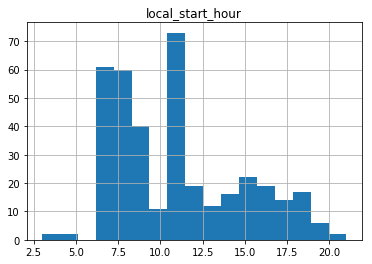

In [91]:
# For each location, the distribution of departure time will be
sample = data.loc[data['labels']==131]
# sample['local_start_hour'] = sample['local_start_hour'].astype('category')
print(len(sample))
print(set(sample['local_start_hour']))
sample.hist(column='local_start_hour', bins=len(set(sample['local_start_hour'])))

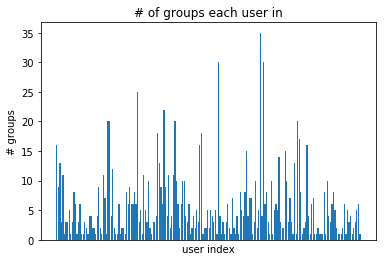

In [155]:
numBar = data.groupby(['user_id']).size().reset_index(name='counts') # 
numBar.head()

# Create bars
height = numBar['counts']
bars = numBar['user_id'].astype('int')
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.title('# of groups each user in')
plt.xlabel('user index')
plt.ylabel('# groups')
plt.xticks([])
# Show graphic
plt.show()

In [156]:
data_2 = pd.merge(wkn_act[['user_id','orig_loc_id','local_start_hour']], df[['orig_loc_id','labels']], on="orig_loc_id")

bins = [0,6,9,13,16,19,24]
labels = [1,2,3,4,5,6]
data_2['start_hour_bin'] = pd.cut(data_2['local_start_hour'], bins=bins, labels=labels)

data_2.head()

,user_id,orig_loc_id,local_start_hour,labels,start_hour_bin
0,2,14,9,131,2
1,2,14,11,131,3
2,2,14,23,131,6
3,2,14,10,131,3
4,2,14,10,131,3


In [157]:
g = data_2.groupby(["start_hour_bin", "labels"])
# for p in g.groups: 
#     print (p, " has ", len(g.groups[p]), " entries")
print(len(g.groups))
data_2['identifier'] = pd.Categorical(data_2['start_hour_bin'].astype(str) + '_' + data_2['labels'].astype(str)).codes
data_2 = data_2.drop_duplicates(subset=['start_hour_bin', 'labels'])
data_2.head()

848


,user_id,orig_loc_id,local_start_hour,labels,start_hour_bin,identifier
0,2,14,9,131,2,95
1,2,14,11,131,3,242
2,2,14,23,131,6,732
5,2,14,19,131,5,576
14,2,14,16,131,4,411


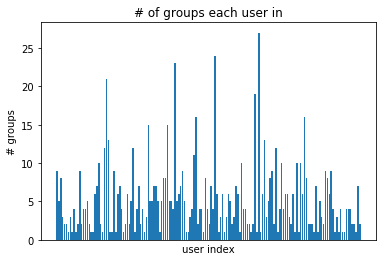

In [158]:
numBar = data_2.groupby(['user_id']).size().reset_index(name='counts') # 
numBar.head()

# Create bars
height = numBar['counts']
bars = numBar['user_id'].astype('int')
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.title('# of groups each user in')
plt.xlabel('user index')
plt.ylabel('# groups')
plt.xticks([])
# Show graphic
plt.show()